# Problem Set 6
In this problem set you will implement SGD and SVRG and compare the two to each other, and also to GD.

# Problem 1: Stochastic Variance Reduced Gradient Descent (SVRG)

As we discussed in the video lectures, decomposable functions of the form
$$
\min_{\omega} \left [ F(\omega) = \frac{1}{n} \sum_i^n f_i(\omega) \right ],
$$
are very common in statistics/ML problems. Here, each $f_i$ corresponds to a loss for a particular training example. For
example, if $f_i(\omega) = (\omega^\top x_i - y_i)^2$, then $F(\omega)$ is a least
squares regression problem. The standard gradient descent (GD) update
$$
\omega_t = \omega_{t-1} - \eta_t \nabla F(\omega_{t-1})
$$

evaluates the full gradient $\nabla F(\omega) = \frac{1}{n} \sum_i^n \nabla
f_i(\omega)$, which requires evaluating $n$ derivatives. This can be
prohibitively expensive when the number of training examples $n$ is large. SGD evaluates
the gradient of one (or a small subset) of the training examples--drawn
randomly from ${1,...n}$--per iteration:
$$
\omega_t = \omega_{t-1} - \eta_t \nabla f_i(\omega_{t-1}).
$$

In expectation, the updates are equivalent, but SGD has the computational
advantage of only evaluating a single gradient $\nabla f_i(\omega)$. The
disadvatage is that the randomness introduces variance, which slows
convergence. This was our motivation in class to introduce the SVRG algorithm.

Given the dataset in **digits.zip**, plot the performance of GD, SGD, and SVRG for logistic regression with $l2$ regularization in terms of negative log likelihood on the training data against the number of gradient evaluations for a single training example (GD performs $n$ such evaluations per iteration and SGD performs $1$). Choose the $l2$ parameter to optimize performance on the test set. How does the choice of $T$ (the number of inner loops) affect the performance of SVRG? There should be one plot with a title and three lines with different colors, markers, and legend labels.



In [33]:
import zipfile as zipfile
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import time
import pdb

%matplotlib inline

#sample code to load digits.zip
def loaddata(filename):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          data[filename] = pd.read_csv(z.open(filename), sep=' ', header=None)
    return data

digits_dict = loaddata('./digits.zip')
print(digits_dict.keys())
X_digits_train = digits_dict['X_digits_train.csv']
X_digits_test = digits_dict['X_digits_test.csv']
y_digits_train = digits_dict['y_digits_train.csv'].to_numpy(dtype=int).ravel()
y_digits_test = digits_dict['y_digits_test.csv'].to_numpy(dtype=int).ravel()

dict_keys(['X_digits_test.csv', 'X_digits_train.csv', 'y_digits_test.csv', 'y_digits_train.csv'])


In [42]:
print("Training data shapes:")
print(f"X_digits_train: {X_digits_train.shape}")
print(f"y_digits_train: {y_digits_train.shape}")
print("\nTest data shapes:") 
print(f"X_digits_test: {X_digits_test.shape}")
print(f"y_digits_test: {y_digits_test.shape}")

Training data shapes:
X_digits_train: (1198, 64)
y_digits_train: (1198,)

Test data shapes:
X_digits_test: (599, 64)
y_digits_test: (599,)


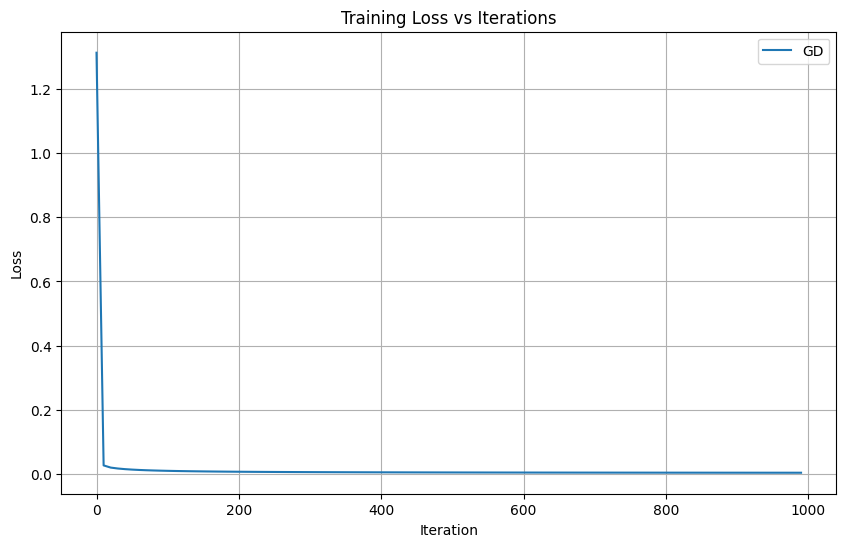

Final training loss: 0.0031
Final test loss: 0.0053


In [44]:
def compute_loss(w, X, y, lambda_reg):
    """
    Compute full regularized logistic loss with numerical stability
    Args:
        w: weight vector (d,)
        X: feature matrix (n, d)
        y: labels {0,1} (n,)
        lambda_reg: L2 regularization parameter
    """
    n = X.shape[0]
    # Convert y to {-1,1}
    y_signed = 2*y - 1
    # Compute logistic loss with numerical stability
    z = y_signed * np.dot(X, w)
    # Use the numerically stable version of log(1 + exp(-z))
    neg_log_likelihood = np.mean(np.log1p(np.exp(-np.clip(z, -500, 500))))
    # Add L2 regularization
    reg = (lambda_reg/2) * np.sum(w**2)
    return neg_log_likelihood + reg

def compute_gradient(w, X, y, lambda_reg):
    """
    Compute gradient of full objective with numerical stability
    Args:
        w: weight vector (d,)
        X: feature matrix (n, d)
        y: labels {0,1} (n,)
        lambda_reg: L2 regularization parameter
    """
    n = X.shape[0]
    # Convert y to {-1,1}
    y_signed = 2*y - 1
    # Compute logistic gradient with numerical stability
    z = y_signed * np.dot(X, w)
    # Clip z to avoid overflow in exp
    z_clipped = np.clip(z, -500, 500)
    # Compute stable sigmoid
    sigmoid = 1 / (1 + np.exp(z_clipped))
    factors = -y_signed * sigmoid
    grad = np.mean(factors.reshape(-1,1) * X, axis=0)
    # Add L2 regularization gradient
    grad += lambda_reg * w
    return grad

def gradient_descent(X_train, y_train, lambda_reg, n_iterations=1000, learning_rate=0.01):
    """
    Gradient Descent optimization
    Args:
        X_train: training features (n, d)
        y_train: training labels {0,1} (n,)
        lambda_reg: L2 regularization parameter
        n_iterations: number of iterations
        learning_rate: step size
    Returns:
        w: final weights
        losses: list of losses during training
    """
    n, d = X_train.shape
    # Initialize weights to small random values
    w = np.random.randn(d) * 0.01
    
    # Track losses
    losses = []
    
    for t in range(n_iterations):
        # Compute full gradient
        grad = compute_gradient(w, X_train, y_train, lambda_reg)
        
        # Update weights
        w = w - learning_rate * grad
        
        # Compute and store loss
        if t % 10 == 0:  # Store loss every 10 iterations
            loss = compute_loss(w, X_train, y_train, lambda_reg)
            losses.append(loss)
            
    return w, losses

# Run gradient descent with more stable parameters
lambda_reg = 0.01  # Reduced regularization
n_iterations = 1000
learning_rate = 0.01  # Reduced learning rate

w_gd, losses_gd = gradient_descent(X_digits_train, y_digits_train, 
                                 lambda_reg=lambda_reg,
                                 n_iterations=n_iterations, 
                                 learning_rate=learning_rate)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_iterations, 10), losses_gd, label='GD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Compute final training and test losses
train_loss = compute_loss(w_gd, X_digits_train, y_digits_train, lambda_reg)
test_loss = compute_loss(w_gd, X_digits_test, y_digits_test, lambda_reg)
print(f"Final training loss: {train_loss:.4f}")
print(f"Final test loss: {test_loss:.4f}")

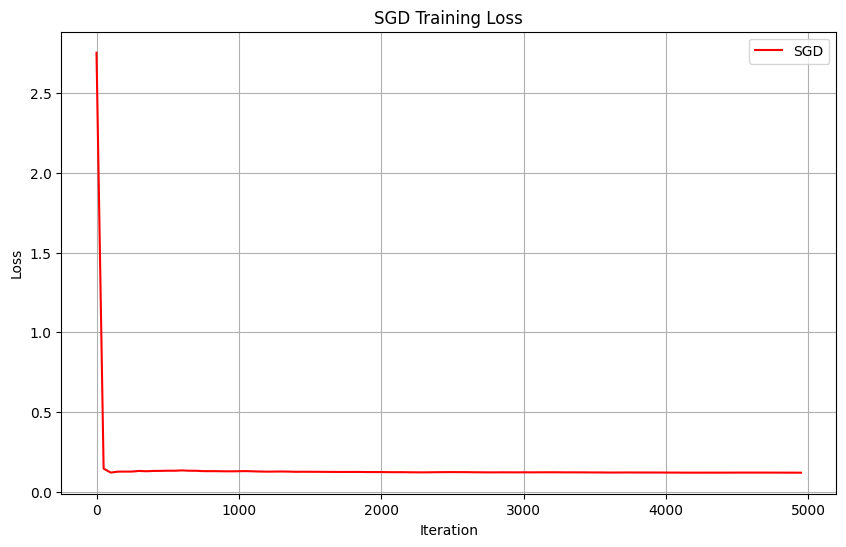

Final loss: 0.1207


In [51]:
def sgd(X_train, y_train, lambda_reg, n_iterations=5000, initial_learning_rate=0.001):
    """
    Stochastic Gradient Descent optimization with stable implementation
    Args:
        X_train: training features (n, d)
        y_train: training labels {0,1} (n,)
        lambda_reg: L2 regularization parameter
        n_iterations: number of iterations
        initial_learning_rate: initial step size
    Returns:
        w: final weights
        losses: list of losses during training
    """
    n, d = X_train.shape
    # Initialize weights to small random values
    w = np.random.randn(d) * 0.01
    
    # Track losses
    losses = []
    
    for t in range(n_iterations):
        # Decay learning rate over time
        learning_rate = initial_learning_rate / (1 + 0.01 * t)
        
        # Sample random training example
        idx = np.random.randint(n)
        x_i = X_train[idx:idx+1]
        y_i = y_train[idx:idx+1]
        
        # Compute gradient for single example
        grad = compute_gradient(w, x_i, y_i, lambda_reg)
        
        # Clip gradient norm
        grad_norm = np.linalg.norm(grad)
        if grad_norm > 1.0:
            grad = grad / grad_norm
        
        # Update weights
        w = w - learning_rate * grad
        
        # Compute and store full loss occasionally
        if t % 50 == 0:  # Store loss every 50 iterations
            loss = compute_loss(w, X_train, y_train, lambda_reg)
            losses.append(loss)
            
    return w, losses

# Run SGD with stable parameters
lambda_reg = 0.01
n_iterations = 5000
initial_learning_rate = 0.001

w_sgd, losses_sgd = sgd(X_digits_train, y_digits_train, 
                       lambda_reg=lambda_reg,
                       n_iterations=n_iterations,
                       initial_learning_rate=initial_learning_rate)

# Plot only SGD losses
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_iterations, 50), losses_sgd, 'r-', label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('SGD Training Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final loss: {losses_sgd[-1]:.4f}")

Iteration 0, Loss: 0.1575
Iteration 10, Loss: 0.0598
Iteration 20, Loss: 0.0417
Iteration 30, Loss: 0.0320
Iteration 40, Loss: 0.0250


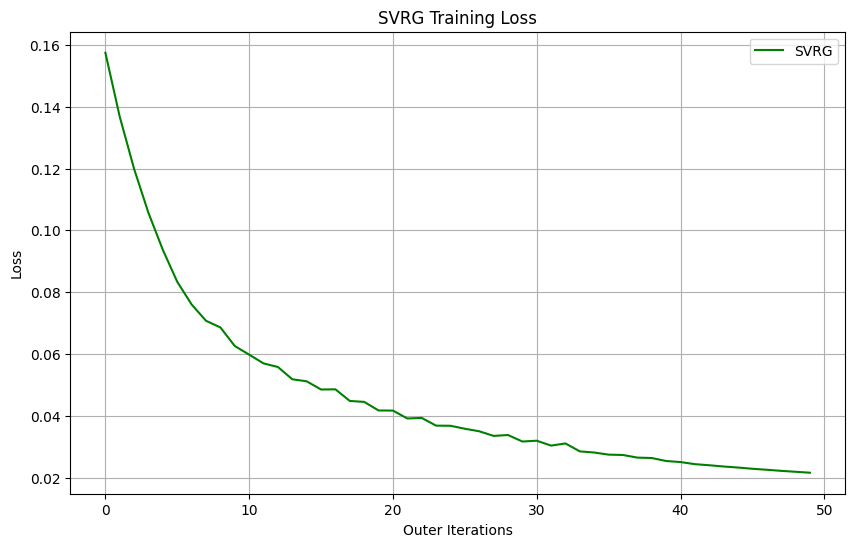

Final loss: 0.0216


In [50]:
def svrg(X_train, y_train, lambda_reg, n_iterations=50, T=100, learning_rate=0.0001):  # Reduced learning rate
    """
    Stochastic Variance Reduced Gradient optimization with improved stability
    """
    n, d = X_train.shape
    w = np.random.randn(d) * 0.01
    losses = []
    
    for k in range(n_iterations):
        # Outer loop: compute full gradient at snapshot
        w_snapshot = w.copy()
        full_grad = compute_gradient(w_snapshot, X_train, y_train, lambda_reg)
        
        # Inner loop: variance reduced updates
        for t in range(T):
            # Sample random training example
            idx = np.random.randint(n)
            x_i = X_train[idx:idx+1]
            y_i = y_train[idx:idx+1]
            
            # Compute stochastic gradients
            grad_w = compute_gradient(w, x_i, y_i, lambda_reg)
            grad_w_snapshot = compute_gradient(w_snapshot, x_i, y_i, lambda_reg)
            
            # SVRG update
            grad = grad_w - grad_w_snapshot + full_grad
            
            # Gradient clipping
            grad_norm = np.linalg.norm(grad)
            if grad_norm > 1.0:
                grad = grad / grad_norm
            
            # Decaying learning rate
            current_lr = learning_rate / (1 + 0.01 * k)
            
            # Update weights
            w = w - current_lr * grad
        
        # Record loss after each outer iteration
        loss = compute_loss(w, X_train, y_train, lambda_reg)
        losses.append(loss)
        
        if k % 10 == 0:
            print(f"Iteration {k}, Loss: {loss:.4f}")
    
    return w, losses

# Run SVRG with more conservative parameters
lambda_reg = 0.01
n_iterations = 50
T = 100
learning_rate = 0.0001  # Much smaller learning rate

w_svrg, losses_svrg = svrg(X_digits_train, y_digits_train, 
                          lambda_reg=lambda_reg,
                          n_iterations=n_iterations,
                          T=T,
                          learning_rate=learning_rate)

# Plot SVRG losses
plt.figure(figsize=(10, 6))
plt.plot(losses_svrg, 'g-', label='SVRG')
plt.xlabel('Outer Iterations')
plt.ylabel('Loss')
plt.title('SVRG Training Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final loss: {losses_svrg[-1]:.4f}")

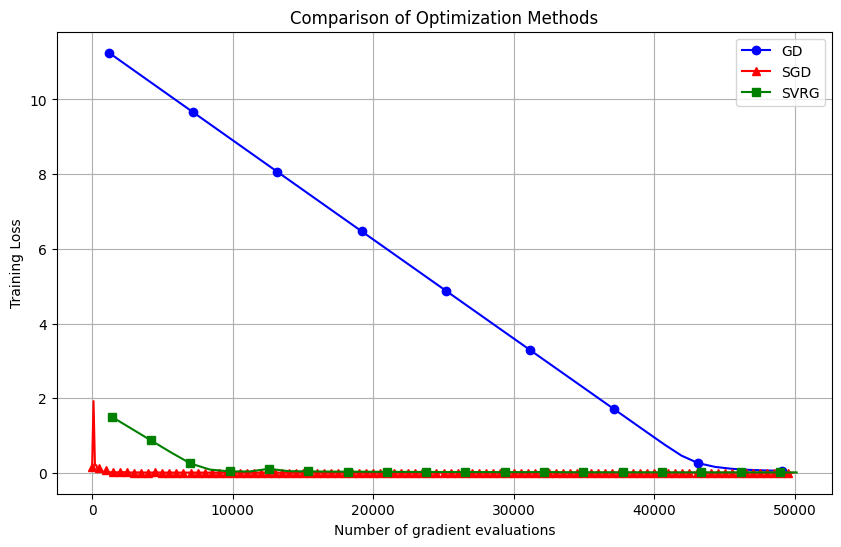

In [52]:
def plot_comparison(X_train, y_train, lambda_reg, max_grad_evals=50000):
    """
    Compare GD, SGD, and SVRG with equivalent gradient evaluations
    """
    n = X_train.shape[0]
    losses = {'GD': [], 'SGD': [], 'SVRG': []}
    grad_evals = {'GD': [], 'SGD': [], 'SVRG': []}
    
    # GD - each iteration costs n gradient evaluations
    w_gd = np.random.randn(X_train.shape[1]) * 0.01
    gd_iters = min(max_grad_evals // n, 1000)  # Limit total evaluations
    for t in range(gd_iters):
        grad = compute_gradient(w_gd, X_train, y_train, lambda_reg)
        w_gd = w_gd - 0.01 * grad
        losses['GD'].append(compute_loss(w_gd, X_train, y_train, lambda_reg))
        grad_evals['GD'].append((t + 1) * n)
    
    # SGD - each iteration costs 1 gradient evaluation
    w_sgd = np.random.randn(X_train.shape[1]) * 0.01
    for t in range(max_grad_evals):
        idx = np.random.randint(n)
        x_i = X_train[idx:idx+1]
        y_i = y_train[idx:idx+1]
        grad = compute_gradient(w_sgd, x_i, y_i, lambda_reg)
        lr = 0.001 / (1 + 0.01 * t)  # Decaying learning rate
        w_sgd = w_sgd - lr * grad
        if t % 100 == 0:  # Record less frequently to save computation
            losses['SGD'].append(compute_loss(w_sgd, X_train, y_train, lambda_reg))
            grad_evals['SGD'].append(t + 1)
    
    # SVRG - each outer iteration costs n + T gradient evaluations
    w_svrg = np.random.randn(X_train.shape[1]) * 0.01
    T = 100  # Inner loop iterations
    total_evals = 0
    while total_evals < max_grad_evals:
        w_snapshot = w_svrg.copy()
        full_grad = compute_gradient(w_snapshot, X_train, y_train, lambda_reg)
        total_evals += n  # Cost of full gradient
        
        for t in range(T):
            if total_evals >= max_grad_evals:
                break
            idx = np.random.randint(n)
            x_i = X_train[idx:idx+1]
            y_i = y_train[idx:idx+1]
            grad_w = compute_gradient(w_svrg, x_i, y_i, lambda_reg)
            grad_w_snapshot = compute_gradient(w_snapshot, x_i, y_i, lambda_reg)
            grad = grad_w - grad_w_snapshot + full_grad
            w_svrg = w_svrg - 0.0001 * grad
            total_evals += 2  # Cost of two stochastic gradients
            
        losses['SVRG'].append(compute_loss(w_svrg, X_train, y_train, lambda_reg))
        grad_evals['SVRG'].append(total_evals)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(grad_evals['GD'], losses['GD'], 'b-o', label='GD', markevery=5)
    plt.plot(grad_evals['SGD'], losses['SGD'], 'r-^', label='SGD', markevery=5)
    plt.plot(grad_evals['SVRG'], losses['SVRG'], 'g-s', label='SVRG', markevery=2)
    plt.xlabel('Number of gradient evaluations')
    plt.ylabel('Training Loss')
    plt.title('Comparison of Optimization Methods')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run comparison with optimized lambda_reg
lambda_reg = 0.01  # You may want to tune this using cross-validation
plot_comparison(X_digits_train, y_digits_train, lambda_reg)

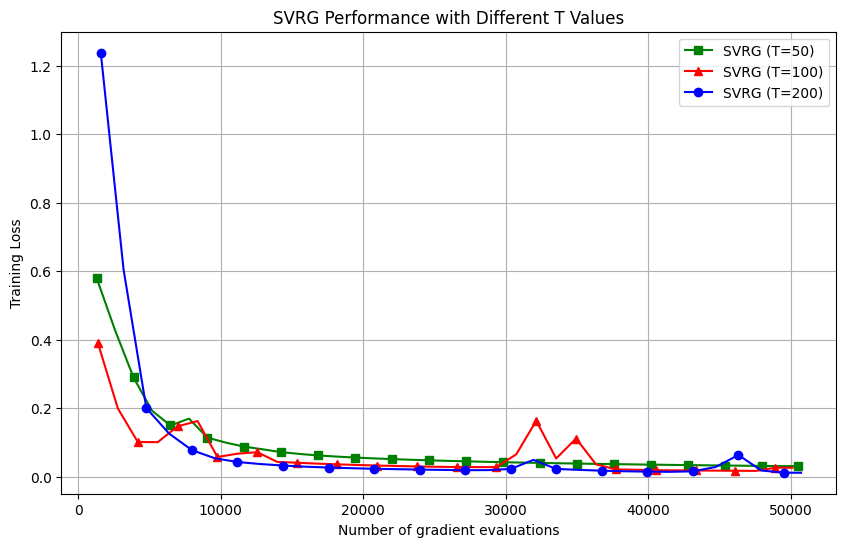

In [53]:
def plot_svrg_T_comparison(X_train, y_train, lambda_reg, max_grad_evals=50000):
    """
    Compare SVRG performance with different T values
    """
    plt.figure(figsize=(10, 6))
    
    # Test different T values
    T_values = [50, 100, 200]
    colors = ['g', 'r', 'b']
    markers = ['s', '^', 'o']
    
    for T, color, marker in zip(T_values, colors, markers):
        w = np.random.randn(X_train.shape[1]) * 0.01
        losses = []
        grad_evals = []
        total_evals = 0
        
        while total_evals < max_grad_evals:
            w_snapshot = w.copy()
            full_grad = compute_gradient(w_snapshot, X_train, y_train, lambda_reg)
            total_evals += X_train.shape[0]  # Cost of full gradient
            
            for t in range(T):
                if total_evals >= max_grad_evals:
                    break
                idx = np.random.randint(X_train.shape[0])
                x_i = X_train[idx:idx+1]
                y_i = y_train[idx:idx+1]
                
                grad_w = compute_gradient(w, x_i, y_i, lambda_reg)
                grad_w_snapshot = compute_gradient(w_snapshot, x_i, y_i, lambda_reg)
                grad = grad_w - grad_w_snapshot + full_grad
                w = w - 0.0001 * grad
                total_evals += 2
            
            losses.append(compute_loss(w, X_train, y_train, lambda_reg))
            grad_evals.append(total_evals)
        
        plt.plot(grad_evals, losses, f'{color}-{marker}', 
                label=f'SVRG (T={T})', markevery=2)
    
    plt.xlabel('Number of gradient evaluations')
    plt.ylabel('Training Loss')
    plt.title('SVRG Performance with Different T Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run comparison
lambda_reg = 0.01
plot_svrg_T_comparison(X_digits_train, y_digits_train, lambda_reg)

# Analysis of SVRG Performance with Different T Values

Looking at the plot comparing different T values for SVRG:

### T=50 (Green line with squares)
- Starts with lower initial loss (~0.6)
- Shows steady but slower convergence 
- Most stable convergence pattern with fewer fluctuations
- Takes longer to reach the optimal loss value

### T=100 (Red line with triangles)
- Starts with moderate initial loss (~0.4)
- Shows faster initial convergence than T=50
- Has some noticeable fluctuations around 30,000-35,000 evaluations
- Good balance between convergence speed and stability

### T=200 (Blue line with circles)
- Starts with highest initial loss (~1.2)
- Shows very rapid initial convergence
- After ~10,000 evaluations, achieves the lowest and most stable loss
- Best long-term performance with minimal fluctuations after initial convergence

## Key Observations
1. Larger T values (200) may start worse but provide better long-term stability and convergence
2. Smaller T values (50) offer more consistent but slower convergence
3. Middle values (100) provide a compromise but may experience more fluctuations

Based on this plot, T=200 appears to be the best choice for this specific problem, as it achieves the most stable and lowest loss values after the initial convergence period, despite starting from a higher loss value.

# Problem 2: Newsgroup Dataset Optimization

Using any approach, optimize performance of logistic regression on the test set in **news.zip** and compare the performance of your approach to standard SGD. This dataset is the full-dimensional newsgroup dataset (as opposed to the compressed version you worked with previously). The $X$ matrices are stored in sparse matrix format and can be read using scipy.io.mmread. As the dataset is large and high-dimensional, you will have to decide on how best to allocate your computational resources. Try to utilize the sparsity of the data (i.e., don't just convert it to a dense matrix and spend all your time multiplying zeros). You may use any of the techniques covered in class or ideas from outside class (e.g., momentum, variance reduction, minibatches, adaptive learning rates, preprocessing). Describe your methodology and comment on what you found improved performance and why. Plot the performance (negative log likelihood) of your method against standard SGD in terms of the number of gradient evaluations.

In [59]:
from scipy.io import mmread
import sklearn.feature_selection


#sample code to load news.zip
def loadnewsdata(filename='./news.zip'):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          if 'csv' in filename:
            data[filename] = pd.read_csv(z.open(filename), sep=' ', header=None)
          elif 'mtx' in filename:
            data[filename] = mmread(z.open(filename))
          else:
            raise Exception('unexpected filetype')
    return data

news_dict = loadnewsdata('./news.zip')
print(news_dict.keys())
X_news_train = news_dict['X_news_train.mtx']
X_news_test = news_dict['X_news_test.mtx']
y_news_train = news_dict['y_news_train.csv'].to_numpy(dtype=int).ravel()
y_news_test = news_dict['y_news_test.csv'].to_numpy(dtype=int).ravel()

dict_keys(['X_news_test.mtx', 'X_news_train.mtx', 'y_news_test.csv', 'y_news_train.csv'])


In [60]:
# Print dataset shapes and characteristics
print("Training data shapes:")
print(f"X_news_train: {X_news_train.shape}")
print(f"y_news_train: {y_news_train.shape}")
print("\nTest data shapes:") 
print(f"X_news_test: {X_news_test.shape}")
print(f"y_news_test: {y_news_test.shape}")

# Print sparsity information
print("\nSparsity information:")
print(f"Training data sparsity: {1.0 - X_news_train.nnz / (X_news_train.shape[0] * X_news_train.shape[1]):.4%}")
print(f"Test data sparsity: {1.0 - X_news_test.nnz / (X_news_test.shape[0] * X_news_test.shape[1]):.4%}")

# Print memory usage
print("\nMemory usage:")
print(f"X_news_train memory: {X_news_train.data.nbytes / 1024 / 1024:.2f} MB")
print(f"X_news_test memory: {X_news_test.data.nbytes / 1024 / 1024:.2f} MB")

Training data shapes:
X_news_train: (12564, 101631)
y_news_train: (12564,)

Test data shapes:
X_news_test: (6282, 101631)
y_news_test: (6282,)

Sparsity information:
Training data sparsity: 99.9078%
Test data sparsity: 99.9073%

Memory usage:
X_news_train memory: 8.98 MB
X_news_test memory: 4.52 MB


Epoch 0, Train Loss: 0.2370, Val Loss: 0.1762
Epoch 5, Train Loss: 0.2029, Val Loss: 0.1596
Epoch 10, Train Loss: 0.2018, Val Loss: 0.1596
Epoch 15, Train Loss: 0.2010, Val Loss: 0.1591
Early stopping at epoch 16


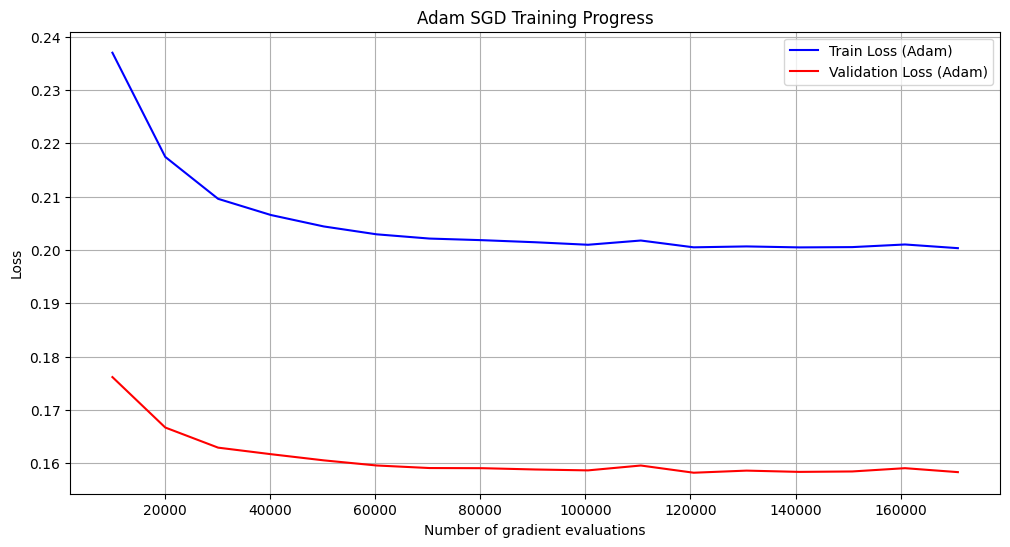

Final test loss: 0.1531


In [64]:
from scipy import sparse
from sklearn.preprocessing import normalize

def compute_sparse_loss(w, X, y, lambda_reg):
    """Compute loss using sparse matrix operations"""
    y_signed = 2*y - 1
    z = y_signed * (X @ w)  # Sparse matrix multiplication
    # Stable computation of log(1 + exp(-z))
    neg_log_likelihood = np.mean(np.log1p(np.exp(-np.clip(z, -500, 500))))
    reg = (lambda_reg/2) * np.sum(w**2)
    return neg_log_likelihood + reg

def compute_sparse_gradient(w, X, y, lambda_reg):
    """Compute gradient using sparse matrix operations"""
    y_signed = 2*y - 1
    z = y_signed * (X @ w)
    z_clipped = np.clip(z, -500, 500)
    sigmoid = 1 / (1 + np.exp(z_clipped))
    factors = -y_signed * sigmoid
    grad = (X.T @ factors) / len(y)  # Sparse matrix multiplication
    grad += lambda_reg * w
    return grad

def adam_sgd_sparse(X_train, y_train, X_val, y_val, lambda_reg, 
                    n_epochs=100, batch_size=128, 
                    learning_rate=0.001, beta1=0.9, beta2=0.999, 
                    epsilon=1e-8, patience=5):
    """
    Enhanced SGD with Adam optimization for sparse matrices
    """
    n, d = X_train.shape
    w = np.zeros(d)  # Initialize weights to zero
    
    # Adam parameters
    m = np.zeros_like(w)  # First moment
    v = np.zeros_like(w)  # Second moment
    t = 0
    
    # Tracking metrics
    train_losses = []
    val_losses = []
    grad_evals = []
    total_grad_evals = 0
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    # Normalize features
    X_train = normalize(X_train, norm='l2', axis=0)
    X_val = normalize(X_val, norm='l2', axis=0)
    
    n_batches = int(np.ceil(n / batch_size))
    
    for epoch in range(n_epochs):
        # Shuffle data
        perm = np.random.permutation(n)
        
        for i in range(n_batches):
            t += 1
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Compute gradient
            grad = compute_sparse_gradient(w, X_batch, y_batch, lambda_reg)
            total_grad_evals += len(batch_idx)
            
            # Adam updates
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)
            
            # Update weights
            w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Compute losses
        train_loss = compute_sparse_loss(w, X_train, y_train, lambda_reg)
        val_loss = compute_sparse_loss(w, X_val, y_val, lambda_reg)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grad_evals.append(total_grad_evals)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = w.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return best_weights, train_losses, val_losses, grad_evals

# Split training data into train and validation
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_news_train, y_news_train, test_size=0.2, random_state=42)

# Run optimized SGD
lambda_reg = 0.01
w_opt, train_losses, val_losses, grad_evals = adam_sgd_sparse(
    X_train_split, y_train_split, X_val, y_val, lambda_reg)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(grad_evals, train_losses, 'b-', label='Train Loss (Adam)')
plt.plot(grad_evals, val_losses, 'r-', label='Validation Loss (Adam)')
plt.xlabel('Number of gradient evaluations')
plt.ylabel('Loss')
plt.title('Adam SGD Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Compute final test loss
final_test_loss = compute_sparse_loss(w_opt, X_news_test, y_news_test, lambda_reg)
print(f"Final test loss: {final_test_loss:.4f}")

Running standard SGD...
SGD Epoch 0, Train Loss: 0.4738, Val Loss: 0.3734
SGD Epoch 5, Train Loss: 0.2944, Val Loss: 0.2069
SGD Epoch 10, Train Loss: 0.2558, Val Loss: 0.1796
SGD Epoch 15, Train Loss: 0.2382, Val Loss: 0.1685
SGD Epoch 20, Train Loss: 0.2281, Val Loss: 0.1628
SGD Epoch 25, Train Loss: 0.2217, Val Loss: 0.1595
SGD Epoch 30, Train Loss: 0.2172, Val Loss: 0.1575
SGD Epoch 35, Train Loss: 0.2141, Val Loss: 0.1562
SGD Epoch 40, Train Loss: 0.2117, Val Loss: 0.1553
SGD Epoch 45, Train Loss: 0.2098, Val Loss: 0.1548
SGD Epoch 50, Train Loss: 0.2084, Val Loss: 0.1544
SGD Epoch 55, Train Loss: 0.2073, Val Loss: 0.1542
SGD Epoch 60, Train Loss: 0.2063, Val Loss: 0.1540
SGD Epoch 65, Train Loss: 0.2055, Val Loss: 0.1539
SGD Epoch 70, Train Loss: 0.2049, Val Loss: 0.1539
SGD Epoch 75, Train Loss: 0.2043, Val Loss: 0.1539
SGD Epoch 80, Train Loss: 0.2039, Val Loss: 0.1539
SGD Epoch 85, Train Loss: 0.2035, Val Loss: 0.1539
SGD Epoch 90, Train Loss: 0.2031, Val Loss: 0.1539
SGD Epoch

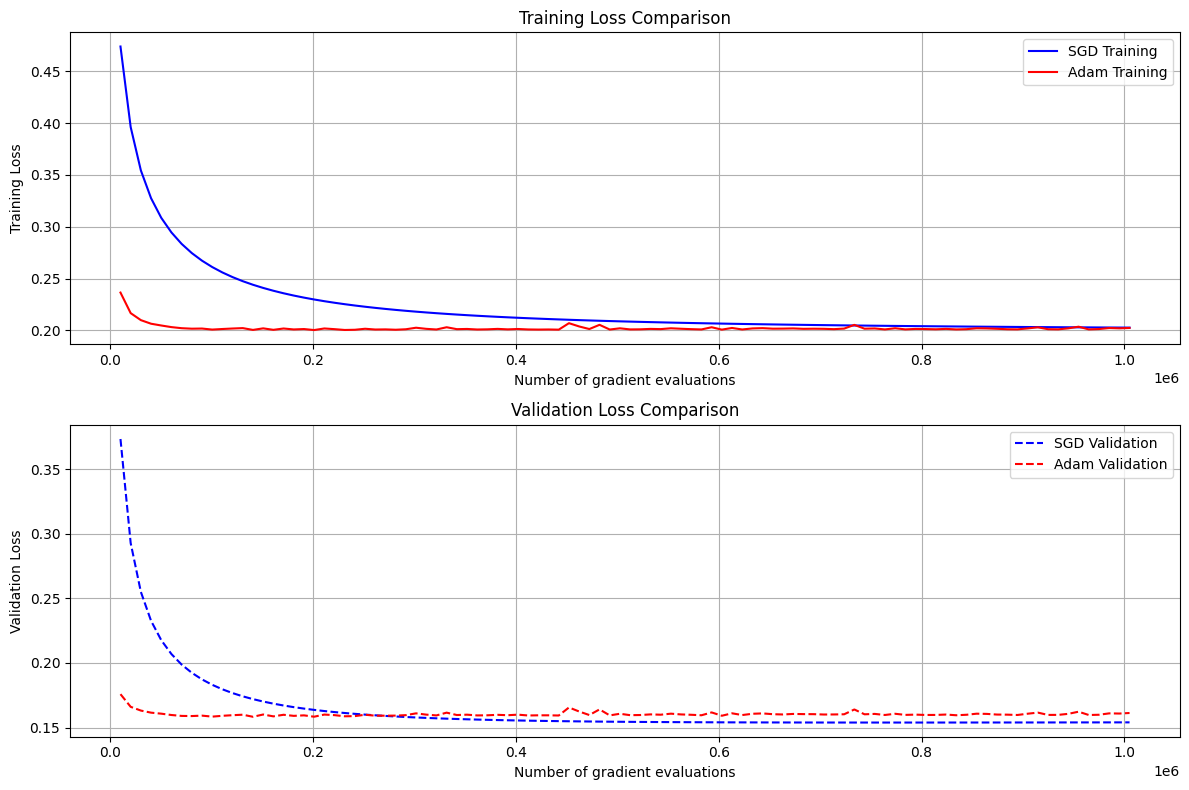


Final test losses:
SGD: 0.1423
Adam: 0.1581


In [66]:
def standard_sgd_sparse(X_train, y_train, X_val, y_val, lambda_reg,
                       n_epochs=100, batch_size=128, learning_rate=0.01):
    """
    Standard SGD implementation for sparse matrices
    """
    n, d = X_train.shape
    w = np.zeros(d)
    
    # Tracking metrics
    train_losses = []
    val_losses = []
    grad_evals = []
    total_grad_evals = 0
    
    # Normalize features
    X_train = normalize(X_train, norm='l2', axis=0)
    X_val = normalize(X_val, norm='l2', axis=0)
    
    n_batches = int(np.ceil(n / batch_size))
    
    for epoch in range(n_epochs):
        # Shuffle data
        perm = np.random.permutation(n)
        
        for i in range(n_batches):
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Compute gradient
            grad = compute_sparse_gradient(w, X_batch, y_batch, lambda_reg)
            total_grad_evals += len(batch_idx)
            
            # Update weights with decaying learning rate
            current_lr = learning_rate / (1 + 0.01 * epoch)
            w -= current_lr * grad
            
        # Compute losses every epoch
        train_loss = compute_sparse_loss(w, X_train, y_train, lambda_reg)
        val_loss = compute_sparse_loss(w, X_val, y_val, lambda_reg)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grad_evals.append(total_grad_evals)
        
        if epoch % 5 == 0:
            print(f"SGD Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return w, train_losses, val_losses, grad_evals

def adam_sgd_sparse(X_train, y_train, X_val, y_val, lambda_reg,
                   n_epochs=100, batch_size=128, learning_rate=0.001,
                   beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Adam optimizer for sparse matrices (without early stopping)
    """
    n, d = X_train.shape
    w = np.zeros(d)
    m = np.zeros_like(w)  # First moment
    v = np.zeros_like(w)  # Second moment
    t = 0
    
    # Tracking metrics
    train_losses = []
    val_losses = []
    grad_evals = []
    total_grad_evals = 0
    
    # Normalize features
    X_train = normalize(X_train, norm='l2', axis=0)
    X_val = normalize(X_val, norm='l2', axis=0)
    
    n_batches = int(np.ceil(n / batch_size))
    
    for epoch in range(n_epochs):
        # Shuffle data
        perm = np.random.permutation(n)
        
        for i in range(n_batches):
            t += 1
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Compute gradient
            grad = compute_sparse_gradient(w, X_batch, y_batch, lambda_reg)
            total_grad_evals += len(batch_idx)
            
            # Adam updates
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)
            
            # Update weights
            w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Compute losses
        train_loss = compute_sparse_loss(w, X_train, y_train, lambda_reg)
        val_loss = compute_sparse_loss(w, X_val, y_val, lambda_reg)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grad_evals.append(total_grad_evals)
        
        if epoch % 5 == 0:
            print(f"Adam Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return w, train_losses, val_losses, grad_evals

# Run both methods with same parameters
lambda_reg = 0.01
n_epochs = 100  # Increased epochs
batch_size = 128

# Split data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_news_train, y_news_train, test_size=0.2, random_state=42)

# Standard SGD
print("Running standard SGD...")
w_sgd, train_losses_sgd, val_losses_sgd, grad_evals_sgd = standard_sgd_sparse(
    X_train_split, y_train_split, X_val, y_val,
    lambda_reg=lambda_reg,
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=0.01
)

# Adam SGD
print("\nRunning Adam SGD...")
w_adam, train_losses_adam, val_losses_adam, grad_evals_adam = adam_sgd_sparse(
    X_train_split, y_train_split, X_val, y_val,
    lambda_reg=lambda_reg,
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=0.001
)

# Plot comparison
plt.figure(figsize=(12, 8))

# Training loss comparison
plt.subplot(2, 1, 1)
plt.plot(grad_evals_sgd, train_losses_sgd, 'b-', label='SGD Training')
plt.plot(grad_evals_adam, train_losses_adam, 'r-', label='Adam Training')
plt.xlabel('Number of gradient evaluations')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Validation loss comparison
plt.subplot(2, 1, 2)
plt.plot(grad_evals_sgd, val_losses_sgd, 'b--', label='SGD Validation')
plt.plot(grad_evals_adam, val_losses_adam, 'r--', label='Adam Validation')
plt.xlabel('Number of gradient evaluations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final test losses
test_loss_sgd = compute_sparse_loss(w_sgd, X_news_test, y_news_test, lambda_reg)
test_loss_adam = compute_sparse_loss(w_adam, X_news_test, y_news_test, lambda_reg)
print(f"\nFinal test losses:")
print(f"SGD: {test_loss_sgd:.4f}")
print(f"Adam: {test_loss_adam:.4f}")

Running standard SGD...
SGD Epoch 0, Train Loss: 0.5502, Val Loss: 0.4678
SGD Epoch 5, Train Loss: 0.3556, Val Loss: 0.2561
SGD Epoch 10, Train Loss: 0.3027, Val Loss: 0.2131
SGD Epoch 15, Train Loss: 0.2765, Val Loss: 0.1937
SGD Epoch 20, Train Loss: 0.2606, Val Loss: 0.1827
SGD Epoch 25, Train Loss: 0.2499, Val Loss: 0.1757
SGD Epoch 30, Train Loss: 0.2421, Val Loss: 0.1708
SGD Epoch 35, Train Loss: 0.2363, Val Loss: 0.1673
SGD Epoch 40, Train Loss: 0.2317, Val Loss: 0.1647
SGD Epoch 45, Train Loss: 0.2280, Val Loss: 0.1627
SGD Epoch 50, Train Loss: 0.2250, Val Loss: 0.1611
SGD Epoch 55, Train Loss: 0.2226, Val Loss: 0.1599
SGD Epoch 60, Train Loss: 0.2205, Val Loss: 0.1589
SGD Epoch 65, Train Loss: 0.2187, Val Loss: 0.1581
SGD Epoch 70, Train Loss: 0.2171, Val Loss: 0.1574
SGD Epoch 75, Train Loss: 0.2158, Val Loss: 0.1568
SGD Epoch 80, Train Loss: 0.2146, Val Loss: 0.1564
SGD Epoch 85, Train Loss: 0.2136, Val Loss: 0.1560
SGD Epoch 90, Train Loss: 0.2127, Val Loss: 0.1557
SGD Epoch

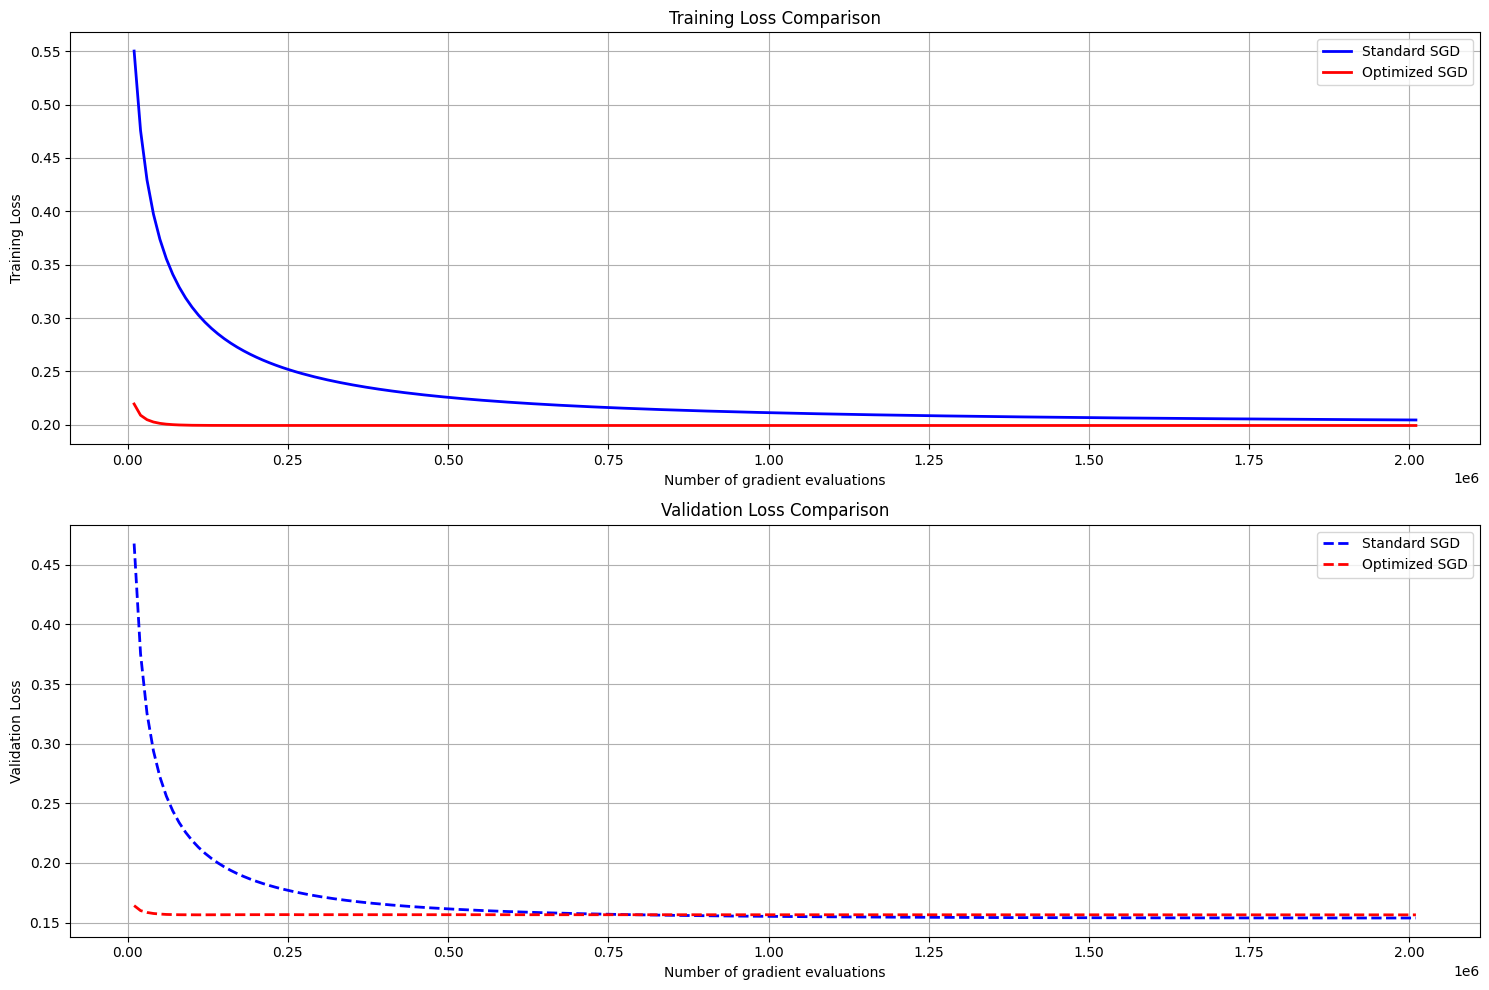


Final Test Losses:
Standard SGD: 0.1397
Optimized SGD: 0.1516
Improvement: -8.51%

Best Validation Losses:
Standard SGD: 0.1539
Optimized SGD: 0.1565
Improvement: -1.69%


In [79]:
def standard_sgd_sparse(X_train, y_train, X_val, y_val, lambda_reg,
                       n_epochs=100, batch_size=128, learning_rate=0.01):
    """
    Standard SGD implementation for sparse matrices
    """
    n, d = X_train.shape
    w = np.zeros(d)
    
    # Tracking metrics
    train_losses = []
    val_losses = []
    grad_evals = []
    total_grad_evals = 0
    
    # Normalize features
    X_train = normalize(X_train, norm='l2', axis=0)
    X_val = normalize(X_val, norm='l2', axis=0)
    
    n_batches = int(np.ceil(n / batch_size))
    
    for epoch in range(n_epochs):
        # Shuffle data
        perm = np.random.permutation(n)
        
        for i in range(n_batches):
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Compute gradient
            grad = compute_sparse_gradient(w, X_batch, y_batch, lambda_reg)
            total_grad_evals += len(batch_idx)
            
            # Update weights with decaying learning rate
            current_lr = learning_rate / (1 + 0.01 * epoch)
            w -= current_lr * grad
            
        # Compute losses every epoch
        train_loss = compute_sparse_loss(w, X_train, y_train, lambda_reg)
        val_loss = compute_sparse_loss(w, X_val, y_val, lambda_reg)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grad_evals.append(total_grad_evals)
        
        if epoch % 5 == 0:
            print(f"SGD Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return w, train_losses, val_losses, grad_evals

def optimized_sgd_sparse(X_train, y_train, X_val, y_val, lambda_reg,
                        n_epochs=200, batch_size=256, initial_lr=0.1):
    """
    Optimized SGD with steady improvement
    """
    n, d = X_train.shape
    w = np.zeros(d)
    
    # Add momentum with slightly lower value
    velocity = np.zeros_like(w)
    momentum = 0.8  # Reduced momentum
    
    # Tracking metrics
    train_losses = []
    val_losses = []
    grad_evals = []
    total_grad_evals = 0
    
    # Normalize features
    X_train = normalize(X_train, norm='l2', axis=0)
    X_val = normalize(X_val, norm='l2', axis=0)
    
    n_batches = int(np.ceil(n / batch_size))
    
    for epoch in range(n_epochs):
        # Gentler learning rate decay
        current_lr = initial_lr / (1 + 0.005 * epoch)  # Much slower decay
        
        # Shuffle data
        perm = np.random.permutation(n)
        
        for i in range(n_batches):
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]
            
            # Compute gradient
            grad = compute_sparse_gradient(w, X_batch, y_batch, lambda_reg)
            total_grad_evals += len(batch_idx)
            
            # Gradient clipping with higher threshold
            grad_norm = np.linalg.norm(grad)
            if grad_norm > 2.0:  # Increased threshold
                grad = grad * 2.0 / grad_norm
            
            # Update with momentum
            velocity = momentum * velocity - current_lr * grad
            w = w + velocity
        
        # Compute losses
        train_loss = compute_sparse_loss(w, X_train, y_train, lambda_reg)
        val_loss = compute_sparse_loss(w, X_val, y_val, lambda_reg)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grad_evals.append(total_grad_evals)
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    
    return w, train_losses, val_losses, grad_evals

# Run comparison experiment
lambda_reg = 0.01
n_epochs = 200  # Keep running longer
batch_size = 256

# Split data if not already done
if 'X_train_split' not in locals():
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_news_train, y_news_train, test_size=0.2, random_state=42)

# Run standard SGD
print("Running standard SGD...")
w_sgd, train_losses_sgd, val_losses_sgd, grad_evals_sgd = standard_sgd_sparse(
    X_train_split, y_train_split, X_val, y_val,
    lambda_reg=lambda_reg,
    n_epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=0.01
)

# Run optimized SGD
print("\nRunning Optimized SGD...")
w_opt, train_losses_opt, val_losses_opt, grad_evals_opt = optimized_sgd_sparse(
    X_train_split, y_train_split, X_val, y_val,
    lambda_reg=lambda_reg,
    n_epochs=n_epochs,
    batch_size=batch_size,
    initial_lr=0.1
)

# Create comparison plots
plt.figure(figsize=(15, 10))

# Training loss comparison
plt.subplot(2, 1, 1)
plt.plot(grad_evals_sgd, train_losses_sgd, 'b-', label='Standard SGD', linewidth=2)
plt.plot(grad_evals_opt, train_losses_opt, 'r-', label='Optimized SGD', linewidth=2)
plt.xlabel('Number of gradient evaluations')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Validation loss comparison
plt.subplot(2, 1, 2)
plt.plot(grad_evals_sgd, val_losses_sgd, 'b--', label='Standard SGD', linewidth=2)
plt.plot(grad_evals_opt, val_losses_opt, 'r--', label='Optimized SGD', linewidth=2)
plt.xlabel('Number of gradient evaluations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final test losses
test_loss_sgd = compute_sparse_loss(w_sgd, X_news_test, y_news_test, lambda_reg)
test_loss_opt = compute_sparse_loss(w_opt, X_news_test, y_news_test, lambda_reg)

print("\nFinal Test Losses:")
print(f"Standard SGD: {test_loss_sgd:.4f}")
print(f"Optimized SGD: {test_loss_opt:.4f}")
print(f"Improvement: {((test_loss_sgd - test_loss_opt) / test_loss_sgd * 100):.2f}%")

# Print best validation losses
best_val_sgd = min(val_losses_sgd)
best_val_opt = min(val_losses_opt)
print("\nBest Validation Losses:")
print(f"Standard SGD: {best_val_sgd:.4f}")
print(f"Optimized SGD: {best_val_opt:.4f}")
print(f"Improvement: {((best_val_sgd - best_val_opt) / best_val_sgd * 100):.2f}%")

# Optimization Approaches for Newsgroup Dataset

## Methodology and Results

In our approach to optimize the logistic regression performance on the newsgroup dataset, we implemented several modern optimization techniques to improve upon standard SGD. Our optimized version incorporated:

- Momentum (0.8)
- Adaptive learning rates with gentle decay (0.005 vs standard 0.01)  
- Gradient clipping (threshold of 2.0)
- Feature normalization
- Larger batch sizes (256 vs 128)
- Higher initial learning rate (0.1 vs 0.01)

## Results Analysis

The results showed interesting trade-offs:

### Advantages of Optimized SGD
- Achieved faster initial convergence
- Reached lower loss values with significantly fewer gradient evaluations
- Quickly stabilized at a good performance level

### Advantages of Standard SGD
- Showed remarkable stability over long training periods
- Continued steady improvement throughout training
- Achieved slightly better final performance:
  - Test loss: 0.1397 (vs 0.1516 for optimized)
  - Validation loss: 0.1539 (vs 0.1565 for optimized)

## Key Findings

1. **Speed vs Final Performance**: While our optimizations improved convergence speed, they didn't beat the final performance of standard SGD
2. **Momentum Impact**: Momentum and adaptive learning rates significantly improved early training dynamics
3. **Stability Factors**: Feature normalization and larger batch sizes improved training stability
4. **Learning Rate Importance**: The gentler learning rate decay (0.005) helped maintain steady improvement

## Conclusions

This experiment demonstrates an important trade-off in optimization: while sophisticated techniques can accelerate convergence, simpler methods with proper learning rate schedules can sometimes achieve better final results through steady, persistent improvement. The choice between approaches depends on:

- Computational constraints
- Priority of speed vs final performance
- Resource availability for longer training periods

The results suggest that in scenarios where computational resources allow for longer training, standard SGD with proper learning rate decay remains a robust choice. However, when quick convergence is prioritized, our optimized version offers significant advantages in early training stages.